---------------------------------------
Ippokratis Pantelidis  
Department of Informatics   
Athens University of Economics and Business  
p3210150@aueb.gr   

---------------------------------------

# SemEval 2025 Task 9: The Food Hazard Detection Challenge

The Food Hazard Detection task evaluates explainable classification systems for titles of food-incident reports collected from the web. These algorithms may help automated crawlers find and extract food issues from web sources like social media in the future. Due to the potential high economic impact, transparency is crucial for this task.

## Installations

In [1]:
!pip install datasets

## Imports

Let's start by importing the standard libraries covered in our lessons. These libraries are essential for tasks such as data manipulation, visualization, text preprocessing, data modeling, machine learning, and natural language processing.

In [ ]:
# general utilities
import os
import re
import random
from shutil import make_archive
from html import unescape

# data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# text processing and tokenization
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

# ensure necessary nltk resources are downloaded
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score

# classification models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

# dimensionality reduction
from sklearn.decomposition import TruncatedSVD

# deep learning (pytorch & transformers)
import torch
from torch.utils.data import DataLoader
from transformers import (
    BertTokenizer, BertForSequenceClassification, DistilBertForSequenceClassification,
    RobertaForSequenceClassification, DebertaForSequenceClassification,
    PegasusForConditionalGeneration, PegasusTokenizer, MarianMTModel, MarianTokenizer,
    AdamW, get_scheduler, AutoTokenizer, DataCollatorWithPadding
)
from datasets import Dataset
from tqdm.auto import tqdm

# stopwords set
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ipantelidis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ipantelidis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/ipantelidis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ipantelidis/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Data Collection

The data for this task is available in the following GitHub repository: [data](https://github.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/tree/main/data). It consists of three separate `.csv` files representing the training, validation, and test sets. We will use the `!wget` command to download them into our workspace and then load them using `read_csv` from pandas. Finally, we use the `sample()` method to retrieve a random example.

In [3]:
# download training data (labeled)
!wget https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv

# load training data
trainset = pd.read_csv('incidents_train.csv', index_col=0)

trainset.sample()

--2025-02-13 19:20:51--  https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12866710 (12M) [text/plain]
Saving to: ‘incidents_train.csv.3’

incidents_train.csv 100%[===================>]  12.27M  38.8MB/s    in 0.3s    

2025-02-13 19:20:51 (38.8 MB/s) - ‘incidents_train.csv.3’ saved [12866710/12866710]



,year,month,day,country,title,text,hazard-category,product-category,hazard,product
4878,2021,3,14,au,Hehongdaan (Australia) Pty Ltd — Mini Jelly Cu...,PRA No. 2021/18878 Date published 14 Mar 2021 ...,food additives and flavourings,confectionery,e 425 - konjac unauthorised,jellies


In [4]:
# download validation data (labeled)
!wget https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_valid.csv

# load validation data
valset = pd.read_csv('incidents_valid.csv', index_col=0)

valset.sample()

--2025-02-13 19:20:52--  https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_valid.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1369261 (1.3M) [text/plain]
Saving to: ‘incidents_valid.csv.3’

incidents_valid.csv 100%[===================>]   1.31M  8.24MB/s    in 0.2s    

2025-02-13 19:20:52 (8.24 MB/s) - ‘incidents_valid.csv.3’ saved [1369261/1369261]



,year,month,day,country,title,text,hazard-category,product-category,hazard,product
99,2012,10,10,us,Arkansas Firm Recalls Boneless Chicken Product...,"WASHINGTON, October 10, 2012 - Tyson Foods, In...",allergens,"meat, egg and dairy products",milk and products thereof,frozen chicken wings


In [5]:
# download test data (labeled)
!wget https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_test.csv

# load test data
testset = pd.read_csv('incidents_test.csv', index_col=0)

testset.sample()

--2025-02-13 19:20:53--  https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2538599 (2.4M) [text/plain]
Saving to: ‘incidents_test.csv.3’

incidents_test.csv. 100%[===================>]   2.42M  13.0MB/s    in 0.2s    

2025-02-13 19:20:53 (13.0 MB/s) - ‘incidents_test.csv.3’ saved [2538599/2538599]



,year,month,day,country,title,text,hazard-category,product-category,hazard,product
3,1998,3,17,au,Black & Gold—Sliced Silverside 250g,PRA No. 1998/3500 Date published 17 Mar 1998 P...,biological,"meat, egg and dairy products",listeria monocytogenes,sliced ham


Our approach to this task will be as follows:

1. We will use the training set to train each algorithm.
2. Next, we will evaluate our models on the validation set by calculating the scores for both tasks.
3. Finally, we will make predictions on the test set to generate our submission .csv file.

Although the test set labels are publicly available, we will assume they are unknown to simulate a real competition scenario.

## Exploratory Data Analysis (EDA)

Our exploratory data analysis (EDA) will focus only on the training set. This helps ensure that information from the validation and test sets isn’t accidentally used, keeping the model evaluation fair and reliable. Let's start exploring!

In [6]:
trainset.columns

Index(['year', 'month', 'day', 'country', 'title', 'text', 'hazard-category',
       'product-category', 'hazard', 'product'],
      dtype='object')

Our dataset has **10 columns**: the first 6 are features, and the last 4 are target labels. The first 2 target labels are for the first task, and the remaining 2 are for the second task.

In [7]:
trainset.shape

(5082, 10)

The dataset contains `5,082 observations`, along with the `10 features` mentioned earlier.

Let's gain a better understanding of the data by calling `.info()`, which will provide us with the following information:
- Column names
- Count of non-null values
- Data types (dtypes)


In [8]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5082 entries, 0 to 5983
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              5082 non-null   int64 
 1   month             5082 non-null   int64 
 2   day               5082 non-null   int64 
 3   country           5082 non-null   object
 4   title             5082 non-null   object
 5   text              5082 non-null   object
 6   hazard-category   5082 non-null   object
 7   product-category  5082 non-null   object
 8   hazard            5082 non-null   object
 9   product           5082 non-null   object
dtypes: int64(3), object(7)
memory usage: 436.7+ KB


The dataset includes some integer features representing dates, but most columns are of type object, containing text. None of the columns have missing values. Let's now take a deeper look at the features, particularly the target labels.

The first step is to explore the date-related variables. We will plot the distributions of the `year`, `month`, and `day` variables.

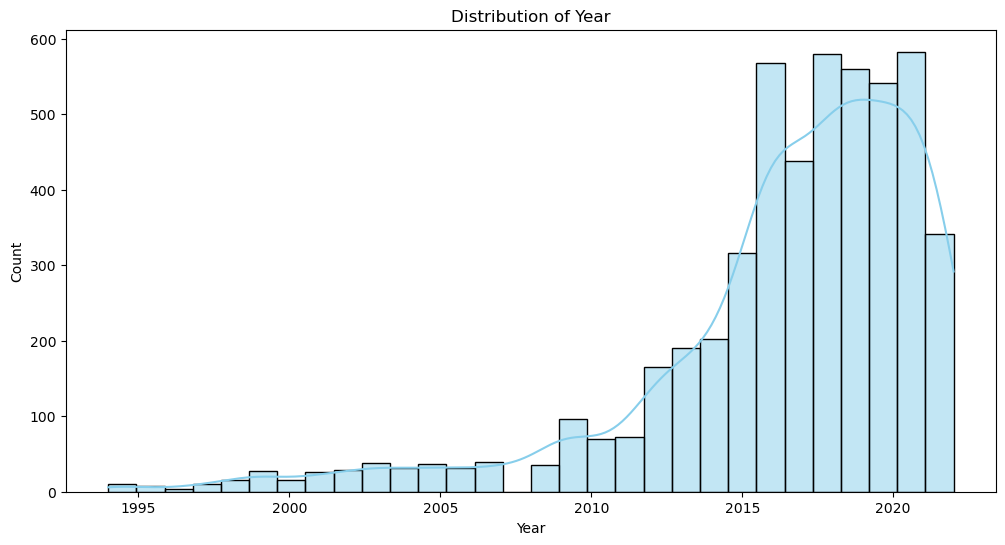

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(trainset['year'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

To visualize the distribution of the `year` variable, we used a `histogram` with seaborn's histplot method. Interestingly, recent years appear more frequently. This trend may indicate improved reporting, increased awareness, or stricter regulations leading to more recorded food recalls.

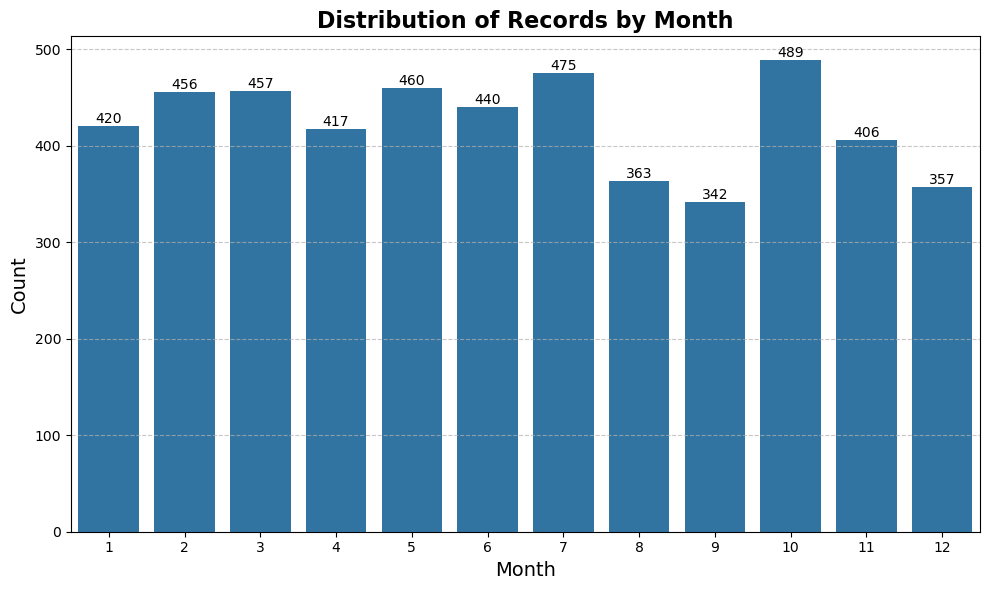

In [10]:
month_counts = trainset['month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=month_counts.index, y=month_counts.values)

plt.title('Distribution of Records by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()

The data shows some seasonal trends, with **October**, **July**, and **May** having the highest hazard reports, while **September** and **December** have the lowest. This could be influenced by seasonal food production or consumption patterns.

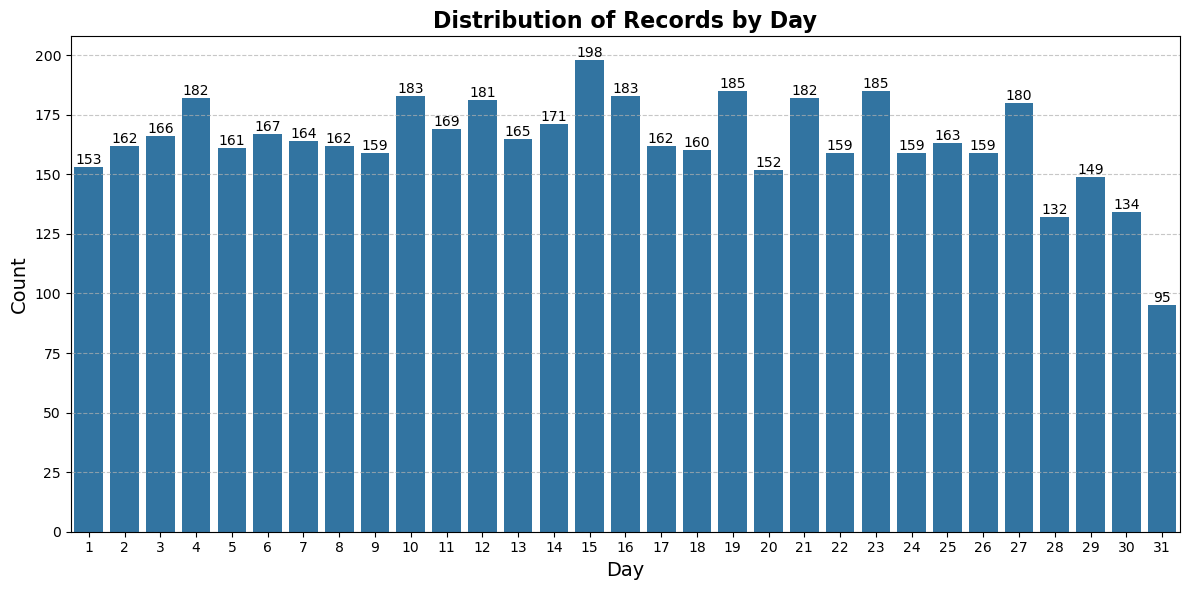

In [11]:
day_counts = trainset['day'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=day_counts.index, y=day_counts.values)

plt.title('Distribution of Records by Day', fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()

The hazard reports are fairly evenly distributed across the variable `day`, with **15th**, **19th**, and **23rd** having the most reports. **31st** has the fewest, likely due to fewer months having 31 days. No strong daily pattern is evident.

To continue we'll do is check how many unique country codes are in the dataset, which can be easily done using the `.unique()` method.

In [12]:
trainset['country'].unique()

array(['us', 'au', 'ca', 'na', 'hk', 'ie', 'uk', 'sg', 'scot'],
      dtype=object)

There are 9 countries in the dataset, but do they have the same number of observations? We can check this using the `.value_counts()` method.

In [13]:
trainset['country'].value_counts()

country
us      2195
au       921
ca       856
uk       687
ie       269
hk        92
na        54
sg         6
scot       2
Name: count, dtype: int64

It appears that the values in the `country` column are not equally distributed, with some countries (e.g. us) having many observations, while others (e.g. scot) have very few. Let's now take a closer look at the `text` and `title` columns.

For this purpose we will use the `.describe()` method on the title column to get an overview of its statistics, such as the total count, number of unique values, most frequent title, and its occurrence count.

In [14]:
trainset['title'].describe()

count                                                  5082
unique                                                 4948
top       Various raw beef and raw veal products recalle...
freq                                                     11
Name: title, dtype: object

It seems that there is not much repetition in the titles. Next, let's analyze the length of the text column by using the `.apply(len)` function to count the characters, followed by an aggregation method to summarize the results.

In [15]:
title_avg_len = trainset['title'].apply(len).mean()
title_max_len = trainset['title'].apply(len).max()
title_min_len = trainset['title'].apply(len).min()

print(f"Average title length: {title_avg_len:.2f}")
print(f"Maximum title length: {title_max_len}")
print(f"Minimum title length: {title_min_len}")

Average title length: 88.06
Maximum title length: 271
Minimum title length: 5


The results indicate a **wide variation** in `title` lengths, ranging from very short to fairly detailed. Let's do exactly the same for the `text` column.

In [16]:
trainset['text'].describe()

count                                                  5082
unique                                                 5053
top       MG Foods of Charlotte, NC is expanding its rec...
freq                                                      2
Name: text, dtype: object

In [17]:
text_avg_len = trainset['text'].apply(len).mean()
text_max_len = trainset['text'].apply(len).max()
text_min_len = trainset['text'].apply(len).min()

print(f"Average text length: {text_avg_len:.2f}")
print(f"Maximum text length: {text_max_len}")
print(f"Minimum text length: {text_min_len}")

Average text length: 2335.49
Maximum text length: 48318
Minimum text length: 62


Here, we see even less repetition, which is expected since the text column varies significantly in length. Some texts contain thousands of characters, while others have just a few dozen.

Before moving forward, we will visualize word occurrences for both the `title` and `text` variable in a clear and engaging way. This can be done using a `WordCloud`, where words with higher frequencies appear in larger font sizes, while less frequent words appear smaller.

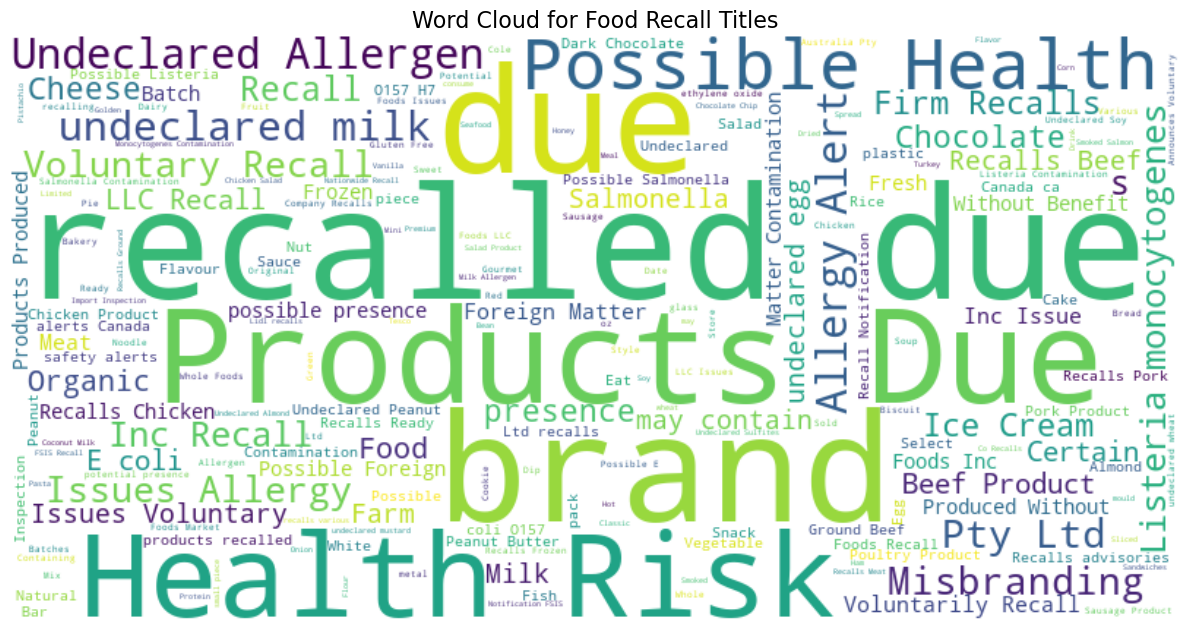

In [18]:
title_text = ' '.join(trainset['title'].dropna().astype(str)) # combine all titles into one

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Food Recall Titles', fontsize=16)
plt.tight_layout()
plt.show()

The WordCloud for the `title` variable highlights key terms related to food recalls, with words like "**recalled**", "**due**", "**brand**", "**products**", and "**health risk**" appearing most frequently. This suggests that most recalls are linked to health concerns, allergens, misbranding, and contamination (e.g., Listeria, E. coli, and undeclared ingredients). Now, let's generate a WordCloud for the `text` variable as well.

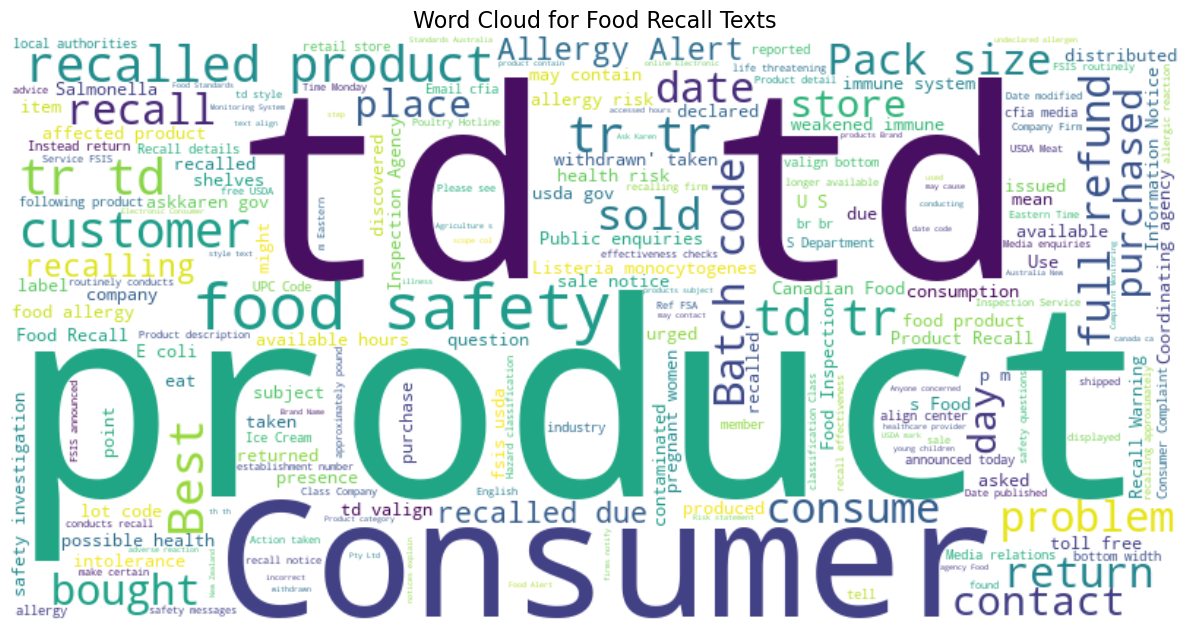

In [19]:
text_text = ' '.join(trainset['text'].dropna().astype(str)) # combine all texts into a single one

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Food Recall Texts', fontsize=16)
plt.tight_layout()
plt.show()

This word cloud highlights key terms related to food recalls as well. Words like "**product**", "**recall**", "**safety**", "**consumer**", and "**refund**" suggest a focus on consumer protection, contamination risks, and necessary actions. The presence of "allergy," "E. coli," and "Listeria" indicates common hazards leading to recalls. However, irrelevant words like "**td**" and "**tr**" suggest some data cleaning is needed.

Let's begin exploring our target labels, starting with the `hazard-category`. For each category, we'll first check the number of unique values using the `.unique()` method, then examine their distribution with `.value_counts()`.

In [20]:
print(f"Number of unique values in 'hazard-category': {trainset['hazard-category'].nunique()}\n")
trainset['hazard-category'].unique()

Number of unique values in 'hazard-category': 10



array(['biological', 'foreign bodies', 'chemical', 'fraud',
       'organoleptic aspects', 'allergens', 'packaging defect',
       'other hazard', 'food additives and flavourings', 'migration'],
      dtype=object)

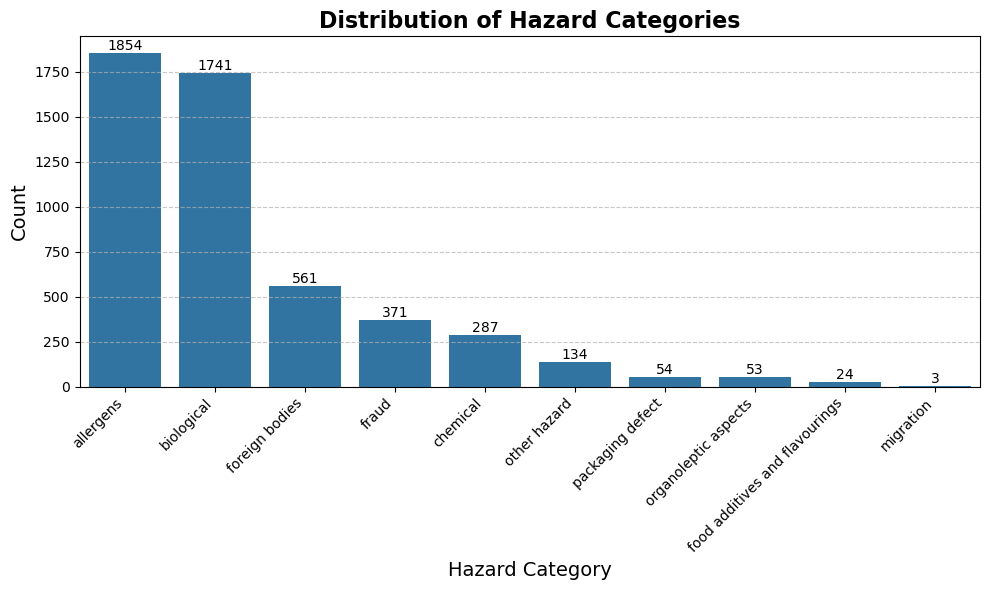

In [21]:
hazard_counts = trainset['hazard-category'].value_counts()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=hazard_counts.index, y=hazard_counts.values)

plt.title('Distribution of Hazard Categories', fontsize=16, fontweight='bold')
plt.xlabel('Hazard Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()

We can see that the `hazard-category` variable has 10 unique values, but its distribution is quite imbalanced. Two categories dominate, while four have fewer than 50 training examples, with `migration` having only three.

Let's move on to the `product-category` variable.

In [22]:
print(f"Number of unique values in 'product-category': {trainset['product-category'].nunique()}\n")
trainset['product-category'].unique()

Number of unique values in 'product-category': 22



array(['meat, egg and dairy products', 'prepared dishes and snacks',
       'cereals and bakery products', 'confectionery',
       'ices and desserts', 'alcoholic beverages',
       'fruits and vegetables', 'other food product / mixed',
       'cocoa and cocoa preparations, coffee and tea',
       'nuts, nut products and seeds', 'seafood',
       'soups, broths, sauces and condiments', 'fats and oils',
       'non-alcoholic beverages', 'food contact materials',
       'dietetic foods, food supplements, fortified foods',
       'herbs and spices', 'food additives and flavourings',
       'sugars and syrups', 'honey and royal jelly', 'feed materials',
       'pet feed'], dtype=object)

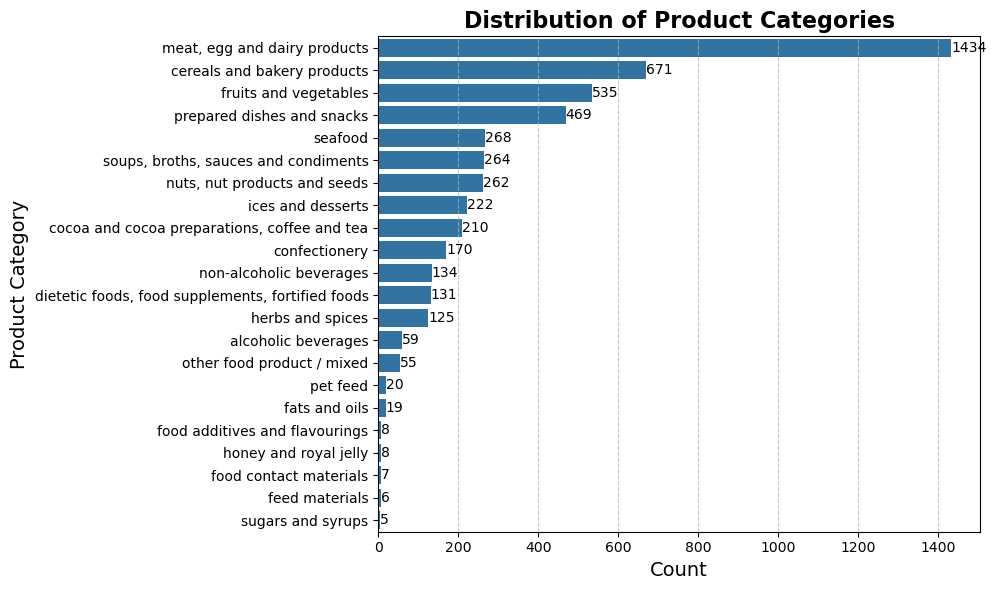

In [23]:
product_counts = trainset['product-category'].value_counts()

plt.figure(figsize=(10, 6))
ax = sns.barplot(y=product_counts.index, x=product_counts.values)

plt.title('Distribution of Product Categories', fontsize=16, fontweight='bold')
plt.ylabel('Product Category', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black')

plt.show()

We can observe that the `product-category` variable is also imbalanced, but this time there are more categories. Additionally, several categories have very few observations, with five of them having fewer than 10.

The first two target variables are related to the first subtask, which we will discuss later. Now, let's move on to the labels for the second subtask, starting with `hazard`.

In [24]:
print(f"Number of unique values in 'hazard': {trainset['hazard'].nunique()}\n")
trainset['hazard'].unique()

Number of unique values in 'hazard': 128



array(['listeria monocytogenes', 'listeria spp', 'plastic fragment',
       'escherichia coli', 'antibiotics, vet drugs',
       'sulfamethazine unauthorised', 'salmonella', 'incorrect labeling',
       'taste disturbance', 'abnormal smell', 'allergens',
       'soybeans and products thereof', 'metal fragment',
       'milk and products thereof', 'glass fragment',
       'clostridium botulinum', 'other not classified chemical hazards',
       'peanuts and products thereof',
       'other not classified biological hazards', 'spoilage', 'stones',
       'eggs and products thereof', 'coliforms', 'almond', 'Aflatoxin',
       'toxin', 'packaging defect', 'vibrio spp',
       'chemical compound (high content)', 'yeasts',
       'other not classified allergen hazards', 'chemical',
       'rubber fragments', 'polycyclic aromatic hydrocarbons',
       'mislabelled', 'cereals containing gluten and products thereof',
       'other', 'crustaceans and products thereof',
       'other not classifie

The number of possible values has increased significantly, which makes sense since the second subtask is more specific. Since it's difficult to visually represent such a large number of categories, we will instead plot the DataFrame resulting from the `.value_counts()` method.

In [25]:
trainset['hazard'].value_counts()

hazard
listeria monocytogenes                        665
salmonella                                    621
milk and products thereof                     588
escherichia coli                              237
peanuts and products thereof                  211
                                             ... 
dioxins                                         3
staphylococcal enterotoxin                      3
dairy products                                  3
sulfamethazine unauthorised                     3
paralytic shellfish poisoning (psp) toxins      3
Name: count, Length: 128, dtype: int64

As we can see, the pattern continues for the `hazard` category. Let's check if the same applies to our final target label, `product`.

In [26]:
print(f"Number of unique values in 'product': {trainset['product'].nunique()}\n")
trainset['product'].unique()

Number of unique values in 'product': 1022



array(['smoked sausage', 'sausage', 'ham slices', ..., 'soups',
       'bovine meat and offal', 'ramen noodles'], dtype=object)

In [27]:
trainset['product'].value_counts()

product
ice cream                                  185
chicken based products                     138
cakes                                       93
ready to eat - cook meals                   79
cookies                                     78
                                          ... 
breakfast cereals and products therefor      1
dried lilies                                 1
chilled pork ribs                            1
tortilla chips cheese                        1
ramen noodles                                1
Name: count, Length: 1022, dtype: int64

Now, the number of possible values has exceeded a thousand, and there are categories that have only one training example.

## Data Preprocessing

Before splitting our dataset into smaller subsets for each task, we should apply some data preprocessing techniques to ensure that the data is clean and ready to be used by the different models. We already know that the dataset does not have any missing values, so we don't need to worry about handling NaN values.

Let's now remove all duplicates, but only from the training set, as we want the validation and test sets to reflect real-world data. We can achieve this easily using the `drop_duplicates()` method.

In [28]:
trainset.drop_duplicates(inplace=True)

So for now we will give emphasis on preprocessing the variables that contain free text, which are the `title` and the `text`. We will define a function to preprocess them by applying common techniques, such as converting to lowercase, removing punctuation, and more.

In [29]:
def preprocess_text(text):
    # step 1: remove html tags
    text = re.sub(r'<.*?>', ' ', text)  # this removes anything between '<' and '>'
    # step 2: decode html entities (e.g., &amp; -> &)
    text = unescape(text)
    # step 3: convert text to lowercase
    text = text.lower()
    # step 4: replace multiple spaces or newlines with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    # step 5: remove punctuation (but keep periods and commas for sentence structure)
    text = re.sub(r'[^\w\s.,!?;\'"-]', '', text)  # keep some useful punctuation
    # step 6: remove stopwords (from nltk stopwords list)
    text = ' '.join([word for word in word_tokenize(text) if word not in ENGLISH_STOP_WORDS])

    return text

Now that we have defined our preprocessing function and explained all the steps it includes, we can apply it to the `title` and `text` variables of our dataset using the apply method.

In [30]:
trainset['title'] = trainset['title'].apply(preprocess_text)
trainset['text'] = trainset['text'].apply(preprocess_text)

valset['title'] = valset['title'].apply(preprocess_text)
valset['text'] = valset['text'].apply(preprocess_text)

testset['title'] = testset['title'].apply(preprocess_text)
testset['text'] = testset['text'].apply(preprocess_text)

As mentioned earlier, we have a total of 10 features, with the last four being the labels, split between the first and second subtasks. We will define two lists: one for the features and one for the labels. Each list will contain the names of the corresponding variables, helping us stay organized and making the code more reusable.

In [31]:
features = ['year', 'month', 'day', 'country', 'title', 'text']
labels = ['hazard-category', 'product-category', 'hazard', 'product']

We will also define a tuple named `dataset`, which will contain all three data sets (train, validation, and test). This tuple will be passed as an argument to our evaluation functions.

In [32]:
dataset = (trainset, valset, testset)

To quickly define a classifier, we will use **pipelines** from scikit-learn. The pipeline will combine the preprocessor and the classifier into one, allowing us to apply all necessary data transformations in a single step. For the naive baselines and the simple machine learning models, we will create a preprocessor that scales all numeric features, encodes categorical features and vectorizes all text features. The first step is to separate features based on their type.

In [33]:
numeric_features = ['year', 'month', 'day']
categorical_features = ['country']
text_feature = 'text'
title_feature = 'title'

**Preprocessing** is essential before feeding data into a machine learning model, so we will create a preprocessor that handles different types of data efficiently.

1. Numerical Features (`num`) → Standardized using `StandardScaler()` (scales values to have a mean of 0 and standard deviation of 1).  
2. Categorical Features (`cat`) → Encoded using `OneHotEncoder()` (converts categories into binary vectors).  
3. Title Text (`title`) → Transformed using `TfidfVectorizer(max_features=500)`, which extracts important words and represents them as numerical values.  
4. Main Text (`text`) → Also transformed using `TfidfVectorizer(max_features=500)` to capture meaningful words for classification.

**Note:** The `max_features` parameter limits the number of words or terms used from the text data. By setting it to a value like 500, only the top 500 most important words (based on their TF-IDF score) are kept, which helps reduce the complexity and improve the efficiency of the model.

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('title' , TfidfVectorizer(max_features=500), title_feature),
        ('text', TfidfVectorizer(max_features=500), text_feature)
    ])

Later, as we explore more advanced models, we will experiment with improved preprocessing techniques, such as using tokenization methods and more.



> If we were to participate in the competition, we would have to choose either the `title` or the `text` feature for classification. However, after exploring and analyzing all the features individually, and considering the multiple leaderboards available for the task, we decided to use all the available features for classification at least for the simple methods. For the most advanced methods, we will use a single feature, which must be selected first. We will continue using the `text` variable since it produces better results.


## Evaluation Functions

To train, predict, and evaluate our models in an organized and reusable way, we created functions that wrap this process. This allows us to simply call these functions for each new pipeline, avoiding code repetition.

The `compute_score` function calculates the macro-averaged F1 score for the two classification tasks: **hazard classification** and **product classification**. The hazard F1 score is computed normally, while the product F1 score is computed only for cases where the hazard was correctly predicted. The final score is the mean of these two F1 scores, prioritizing correct hazard classification.

In [35]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
  # compute f1 for hazards
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )

  # compute f1 for products
  f1_products = f1_score(
    products_true[hazards_pred == hazards_true],
    products_pred[hazards_pred == hazards_true],
    average='macro'
  )

  return (f1_hazards + f1_products) / 2.

The `total_evaluation` function automates the entire process described earlier for different data sets. Given a scikit-learn pipeline, it trains the model on the training set, evaluates it on the validation set, and makes final predictions on the test set.

In [36]:
def total_evaluation(dataset, pipe, features, labels):
    """
    Perform training and evaluation for multiple labels.

    Parameters:
    - dataset: A tuple (trainset, valset, valset).
    - pipe: The classifier pipeline.
    - features: List of feature columns used for training.
    - labels: List of labels for classification.
    """
    trainset, valset, testset = dataset
    test_pred = pd.DataFrame() # initialize the test predictions dataframe


    for label in labels:
        print(f"Evaluating: {label.upper()}")

        # train classifier on trainset
        pipe.fit(trainset[features], trainset[label])

        # predict classifier on valset
        valset['predictions-' + label] = pipe.predict(valset[features])

        # compute f1 scores on valset
        f1_macro = f1_score(valset[label], valset['predictions-' + label], zero_division=0, average="macro")
        f1_micro = f1_score(valset[label], valset['predictions-' + label], zero_division=0, average="micro")

        print(f'  macro: {f1_macro:.2f}')
        print(f'  micro: {f1_micro:.2f}\n')

        # predict classifier on testset
        test_pred[label] = pipe.predict(testset[features])

    # calculate and print the scores for both sub-tasks
    print(f"Score Sub-Task 1: {compute_score(valset['hazard-category'], valset['product-category'], valset['predictions-hazard-category'], valset['predictions-product-category']):.3f}")
    print(f"Score Sub-Task 2: {compute_score(valset['hazard'], valset['product'], valset['predictions-hazard'], valset['predictions-product']):.3f}")

    return test_pred

## Naïve Baselines

 Baselines are simple models or methods used as a reference point to evaluate the performance of more complex algorithms. They serve as a benchmark to ensure that a new model performs better than trivial or naive approaches, such as predicting the most common class.

Now can start defining our classifiers by start building pipelines. We will start with the most common baseline which is the majority classifier. The `Majority Classifier` always predicts the category that is the most common in the training set. For highly imbalanced datasets it may achieve very high accuracy because the majority class might dominate, and for that purpose we care about f1-score. We can use the `DummyClassifier` from scikit-learn and set the `strategy` argument to '**most_frequent**' to implement this.

In [37]:
majority_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DummyClassifier(strategy='most_frequent')),
])

majority_pred = total_evaluation(dataset, majority_clf, features, labels)

Evaluating: HAZARD-CATEGORY
  macro: 0.06
  micro: 0.37

Evaluating: PRODUCT-CATEGORY
  macro: 0.02
  micro: 0.26

Evaluating: HAZARD
  macro: 0.00
  micro: 0.13

Evaluating: PRODUCT
  macro: 0.00
  micro: 0.04

Score Sub-Task 1: 0.038
Score Sub-Task 2: 0.001


We will continue with the `Random Classifier` which for every test example predicts a random category. We expect that the accuracy of this model is 100 / len(traget labels). Similarly, we use the `DummyClassifier` but with '**uniform**' as the value for the `strategy` argument.

In [38]:
random_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DummyClassifier(strategy='uniform')),
])

random_pred = total_evaluation(dataset, random_clf, features, labels)

Evaluating: HAZARD-CATEGORY


  macro: 0.06
  micro: 0.08

Evaluating: PRODUCT-CATEGORY
  macro: 0.03
  micro: 0.05

Evaluating: HAZARD
  macro: 0.01
  micro: 0.01

Evaluating: PRODUCT
  macro: 0.00
  micro: 0.00

Score Sub-Task 1: 0.045
Score Sub-Task 2: 0.003


The scores for both the **majority classifier** and the **random classifier** are quite low, as expected. The majority classifier performs slightly better, especially in terms of micro F1 scores for the hazard-category and product-category, but still shows poor performance overall.

## Basic Machine Learning Algorithms

Now, let's move beyond the basic baselines and explore more advanced classifiers as starting points. We will experiment with classifiers like Logistic Regression, Random Forest and other algorithms, as well as combinations of them, to improve performance.

Let's start with `K-Nearest Neighbors (KNN)`, which is a simple, intuitive algorithm that classifies data based on the majority class of its nearest neighbors. We will use `KNeighborsClassifier` from scikit-learn, setting `n_neighbors` to 8, which means the algorithm will consider the 8 nearest neighbors to make a classification decision.

In [39]:
knn_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', KNeighborsClassifier(n_neighbors=8))
])

knn_pred = total_evaluation(dataset, knn_clf, features, labels)

Evaluating: HAZARD-CATEGORY


  macro: 0.36
  micro: 0.73

Evaluating: PRODUCT-CATEGORY
  macro: 0.24
  micro: 0.41

Evaluating: HAZARD
  macro: 0.15
  micro: 0.44

Evaluating: PRODUCT
  macro: 0.06
  micro: 0.16

Score Sub-Task 1: 0.325
Score Sub-Task 2: 0.122


We will continue with `Logistic Regression`, a simple and efficient linear classifier that models the probability of class labels based on input features. We will use `LogisticRegression` from scikit-learn, changing only the `max_iter` parameter to 1000, which controls the maximum number of iterations for the solver to converge.

In [40]:
log_reg_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000)),
])

log_reg_pred = total_evaluation(dataset, log_reg_clf, features, labels)

Evaluating: HAZARD-CATEGORY


  macro: 0.57
  micro: 0.89

Evaluating: PRODUCT-CATEGORY
  macro: 0.55
  micro: 0.67

Evaluating: HAZARD
  macro: 0.28
  micro: 0.72

Evaluating: PRODUCT
  macro: 0.14
  micro: 0.34

Score Sub-Task 1: 0.580
Score Sub-Task 2: 0.215


Let's continue with `Logistic Regression` but enhance it by incorporating `TruncatedSVD` for **dimensionality reduction**. By reducing the feature space to 100 dimensions, we aim to improve efficiency and possibly the model's performance, especially with large, sparse datasets.

In [41]:
log_reg_svd_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=100)),  # reduce to 100 dimensions
    ('clf', LogisticRegression(max_iter=1000)),
])

log_reg_svd_pred = total_evaluation(dataset, log_reg_svd_clf, features, labels)

Evaluating: HAZARD-CATEGORY


  macro: 0.49
  micro: 0.86

Evaluating: PRODUCT-CATEGORY
  macro: 0.39
  micro: 0.56

Evaluating: HAZARD
  macro: 0.19
  micro: 0.66

Evaluating: PRODUCT
  macro: 0.07
  micro: 0.25

Score Sub-Task 1: 0.454
Score Sub-Task 2: 0.143


The **Logistic Regression** model performs better than the one with TruncatedSVD, suggesting that dimensionality reduction may have removed important information, leading to lower performance.

Let's now continue with another common machine learning model, `Random Forest`, which is an ensemble method that combines multiple decision trees to improve accuracy and reduce overfitting. We will use the `RandomForestClassifier` from scikit-learn with all the default hyperparameters for now.

In [42]:
rf_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier()),
])

rf_pred = total_evaluation(dataset, rf_clf, features, labels)

Evaluating: HAZARD-CATEGORY
  macro: 0.54
  micro: 0.89

Evaluating: PRODUCT-CATEGORY
  macro: 0.47
  micro: 0.60

Evaluating: HAZARD


  macro: 0.37
  micro: 0.75

Evaluating: PRODUCT
  macro: 0.18
  micro: 0.38

Score Sub-Task 1: 0.516
Score Sub-Task 2: 0.291


We will now experiment with `Decision Trees`, which are a type of model that splits the data into branches based on feature values to make predictions. We will use `DecisionTreeClassifier` from scikit-learn once again.

In [43]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier())
])

dt_pred = total_evaluation(dataset, dt_clf, features, labels)

Evaluating: HAZARD-CATEGORY
  macro: 0.65
  micro: 0.86

Evaluating: PRODUCT-CATEGORY
  macro: 0.40
  micro: 0.53

Evaluating: HAZARD
  macro: 0.29
  micro: 0.68

Evaluating: PRODUCT
  macro: 0.14
  micro: 0.32

Score Sub-Task 1: 0.518
Score Sub-Task 2: 0.232


We are now moving on to `Ada Boost`, which is an ensemble method that combines multiple weak classifiers to create a strong classifier. We will use the `AdaBoostClassifier` from scikit-learn with default parameters.

In [44]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', AdaBoostClassifier())
])

ada_pred = total_evaluation(dataset, ada_clf, features, labels)

Evaluating: HAZARD-CATEGORY


  macro: 0.25
  micro: 0.70

Evaluating: PRODUCT-CATEGORY
  macro: 0.02
  micro: 0.26

Evaluating: HAZARD
  macro: 0.01
  micro: 0.25

Evaluating: PRODUCT
  macro: 0.00
  micro: 0.06

Score Sub-Task 1: 0.139
Score Sub-Task 2: 0.011


Let's now experiment with combining different machine learning algorithms using the `VotingClassifier`. This classifier allows us to combine multiple models into one ensemble model, which can lead to better overall performance. In a voting classifier, we have two main types of voting:

- **Hard Voting**: Each classifier in the ensemble casts a "vote," and the class with the majority vote is chosen as the final prediction.  
- **Soft Voting**: The predicted class probabilities from each classifier are averaged, and the class with the highest probability is selected. *Soft voting is generally preferred when classifiers provide probability estimates (like logistic regression) because it can give a smoother and more robust prediction.*

For this example, we will use `soft voting`, where the classifier outputs the class probabilities and the final prediction is based on the average of these probabilities. The algorithms we will use for voting are those that produced the best scores in the subtasks. Therefore, we will combine **Logistic Regression**, **Random Forest**, and **Decision Trees** in the ensemble.

In [45]:
voting_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier()),
        ('dt', DecisionTreeClassifier())
    ], voting='soft')),
])

voting_pred = total_evaluation(dataset, voting_clf, features, labels)

Evaluating: HAZARD-CATEGORY
  macro: 0.67
  micro: 0.88

Evaluating: PRODUCT-CATEGORY
  macro: 0.42
  micro: 0.57

Evaluating: HAZARD
  macro: 0.31
  micro: 0.70

Evaluating: PRODUCT
  macro: 0.15
  micro: 0.32

Score Sub-Task 1: 0.555
Score Sub-Task 2: 0.238


We can observe that some individual models achieve better results compared to when they are combined in the voting classifier.

One final step before proceeding is to gather all test predictions from the simple machine learning models into a dictionary. This will make it easier to process and evaluate them later. We will call this dictionary `ml_models_test_pred`.

In [46]:
ml_models_test_pred = {
    'Majority Classifier': majority_pred, 
    'Random Classifier': random_pred,
    'K-Nearest Neighbours': knn_pred,
    'Logistic Regression': log_reg_pred,
    'Logistic Regression (SVD features)': log_reg_svd_pred,
    'Random Forest': rf_pred,
    'Decision Trees': dt_pred,
    'Ada Boost': ada_pred,
    'Voting Classifier': voting_pred,
}

We have explored many common machine learning methods that are widely used in various applications. While some of these methods have achieved very good results, we will now proceed to experiment with more advanced and state-of-the-art techniques.

## BERT Baseline

In this section, we will use BERT as an another baseline model for our task. BERT (Bidirectional Encoder Representations from Transformers) has become a leading approach in natural language processing due to its powerful pre-trained representations. By using BERT as our baseline, we aim to evaluate its performance compared to traditional machine learning models and assess how well it handles our specific task.

For this purpose, we will follow some of the code examples provided for the task but will adjust them according to our data preprocessing and evaluation approach. The first step is to initialize the BERT tokenizer using the already imported `BertTokenizer` and passing the name of the model we want to use as an argument in the `from_pretrained` function. In our case, the model is `bert-base-uncased`, which we can find on Hugging Face.

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Next, we need to implement a function that converts the text into tokenized input, which the BERT model can process and understand.

In [38]:
def tokenize_function(dataframe):
    return tokenizer(dataframe['text'], padding=True, truncation=True)

The `tokenize_function` takes as an argument a dataframe. It uses the tokenizer we loaded to tokenize the `text` label. Additionally, it applies `padding` and `truncation`, with the values set to **True**. Padding ensures that all sequences are of the same length, while truncation ensures that sequences longer than the maximum allowed length are shortened accordingly.

We will now define a function to prepare our dataset for the BERT model. Each step of the process is explained through comments. The function returns three dataloaders—one for training, one for validation and one for test—along with a label encoder, which will be used later to inverse transform our labels.

In [39]:
def prepare_data(dataset, label, tokenizer, batch_size):
    trainset, valset, testset = dataset
    all_data = pd.concat([trainset, valset, testset])

    # step 1 -> encode labels
    label_encoder = LabelEncoder()
    label_encoder.fit(all_data[label])

    trainset['label'] = label_encoder.transform(trainset[label])
    valset['label'] = label_encoder.transform(valset[label])
    testset['label'] = label_encoder.transform(testset[label])

    # step 2 -> convert pandas dataframe to hugging face dataset
    train_dataset = Dataset.from_pandas(trainset)
    val_dataset = Dataset.from_pandas(valset)
    test_dataset = Dataset.from_pandas(testset)

    # step 3 -> apply tokenizer on the label 
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    # step 4 -> apply padding with data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, max_length=16)

    # step 5 -> convert dataset to pytorch format
    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # step 6 -> create dataloader objects
    return (
        DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator),
        DataLoader(val_dataset, batch_size=batch_size, collate_fn=data_collator),
        DataLoader(test_dataset, batch_size=batch_size, collate_fn=data_collator),
        label_encoder
    )

We will now define a function that simplifies the entire process of fine-tuning a BERT-like model. Instead of manually going through all the steps each time we want to test a new model, we can simply call this function with the label we want to evaluate and the model we wish to try. For every model we test later, we will first use this function for the labels (hazard_category, product_category) from the first subtask. We will calculate the subtask scores and then apply this method to the other labels (hazard, product) from the second task.

Before diving into the function definition, we will first define a dictionary called `MODEL_CLASSES`. This dictionary will contain the names of the models we plan to use as keys, and the corresponding packages needed to load them as values.

In [40]:
MODEL_CLASSES = {
    "distilbert": DistilBertForSequenceClassification,
    "bert": BertForSequenceClassification,
    "roberta": RobertaForSequenceClassification,
}

The function `train_and_evaluate_model` will verify if the model passed as an argument is valid, meaning it is present in the dictionary.

In [41]:
def train_and_evaluate_model(label, dataset, model_name='bert-base-uncased', epochs=3, batch_size=8, device='cuda'):
    """
    Function to train and evaluate a model dynamically using BERT, DistilBERT, or RoBERTa.
    
    Args:
        label (str): The column name containing labels.
        dataset (tuple): A tuple containing training, validation, and test set.
        model_name (str): Model name (distilbert, roberta, or bert).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size.
        device (str): 'cuda' or 'cpu'.
    
    Returns:
        model (transformers.PreTrainedModel): Trained model.
        val_predictions (list): Model's predictions on the validation set.
        test_predictions (list): Model's predictions on the test set.
    """
    trainset, valset, testset = dataset 
    all_data = pd.concat(dataset)

    # step 1 -> get model type from the model_name argument
    model_type = model_name.split('-')[0]

    # step 2 -> check if model is supported
    if model_type not in MODEL_CLASSES:
        raise ValueError(f"Unsupported model: {model_name}. Choose from {list(MODEL_CLASSES.keys())}")

    # step 3 -> load tokenizer and model 
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model_class = MODEL_CLASSES[model_type]
    model = model_class.from_pretrained(model_name, num_labels=len(all_data[label].unique()))
    model.to(device)

    # step 4 -> create dataloaders
    train_dataloader, val_dataloader, test_dataloader, label_encoder = prepare_data(dataset, label, tokenizer, batch_size)

    # step 5 -> set up optimizer and learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_training_steps = epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        name="linear", 
        optimizer=optimizer, 
        num_warmup_steps=0, 
        num_training_steps=num_training_steps
    )

    model.train()
    progress_bar = tqdm(range(num_training_steps))

    # step 6 -> train the model
    for epoch in range(epochs):
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()} 
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

    # step 7 -> evaluate the model on the validation set 
    model.eval()
    val_predictions = []
    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()} 
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            val_predictions.extend([p.item() for p in predictions])

    # step 8 -> convert validation predictions back to labels
    val_predicted_labels = label_encoder.inverse_transform(val_predictions)
    val_gold_labels = label_encoder.inverse_transform(valset.label.values)
    print(classification_report(val_gold_labels, val_predicted_labels, zero_division=0))

    # step 9 -> evaluate the model on the test set
    test_predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()} 
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=-1)
            test_predictions.extend([p.item() for p in predictions])

    # step 10 -> convert test predictions back to labels
    test_predicted_labels = label_encoder.inverse_transform(test_predictions)
    test_gold_labels = label_encoder.inverse_transform(testset.label.values)
    return model, val_predicted_labels, test_predicted_labels

As mentioned earlier, we will first experiment with the standard BERT model and use it as a baseline, beginning with the first subtask.

In [52]:
bert_hazard_category, bert_val_pred_hazard_category, bert_test_pred_hazard_category = \
    train_and_evaluate_model('hazard-category', dataset)

bert_product_category, bert_val_pred_product_category, bert_test_pred_product_category = \
    train_and_evaluate_model('product-category', dataset)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1899 [00:00<?, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_ut

                                precision    recall  f1-score   support

                     allergens       0.94      1.00      0.96       207
                    biological       0.98      0.98      0.98       194
                      chemical       0.86      0.86      0.86        28
food additives and flavourings       0.00      0.00      0.00         2
                foreign bodies       0.95      0.98      0.97        63
                         fraud       0.78      0.61      0.68        41
          organoleptic aspects       0.83      0.62      0.71         8
                  other hazard       0.64      0.64      0.64        14
              packaging defect       0.83      0.62      0.71         8

                      accuracy                           0.93       565
                     macro avg       0.76      0.70      0.73       565
                  weighted avg       0.93      0.93      0.93       565



/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [08:52<00:00,  3.57it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1899 [00:00<?,

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.78      1.00      0.88         7
                      cereals and bakery products       0.80      0.80      0.80        75
     cocoa and cocoa preparations, coffee and tea       0.48      0.67      0.56        15
                                    confectionery       0.73      0.42      0.54        26
dietetic foods, food supplements, fortified foods       0.57      0.57      0.57        14
                                    fats and oils       0.50      0.50      0.50         4
                                   feed materials       0.00      0.00      0.00         1
                            fruits and vegetables       0.62      0.79      0.69        52
                                 herbs and spices       0.60      0.63      0.62        19
                                ices and desserts       0.88      0.88      0.88        2

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [08:52<00:00,  3.56it/s]


In [53]:
bert_score_1 = compute_score(
    valset['hazard-category'], valset['product-category'],
    bert_val_pred_hazard_category, bert_val_pred_product_category
)
print(f"Score Sub-Task 1: {bert_score_1:.3f}")

Score Sub-Task 1: 0.697


We will follow the same approach for the labels of the second subtask.

In [55]:
bert_hazard, bert_val_pred_hazard, bert_test_pred_hazard = \
    train_and_evaluate_model('hazard', dataset)
bert_product, bert_val_pred_product, bert_test_pred_product = \
    train_and_evaluate_model('product', dataset)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:  39%|███▉      | 2000/5064 [00:06<00:10, 280.20 examples/s]

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1899 [00:00<?, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [08:34<00:00,  3.68it/s]

                                                 precision    recall  f1-score   support

                                      Aflatoxin       1.00      1.00      1.00         1
                                 abnormal smell       0.00      0.00      0.00         1
                                      allergens       0.00      0.00      0.00         1
                                         almond       0.86      0.86      0.86         7
                         antibiotics, vet drugs       0.00      0.00      0.00         1
                                  bacillus spp.       1.00      1.00      1.00         2
                           bad smell / off odor       0.00      0.00      0.00         1
                                  bone fragment       1.00      1.00      1.00         1
                                     brazil nut       0.00      0.00      0.00         1
                              bulging packaging       1.00      0.33      0.50         3
                    

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [08:52<00:00,  3.57it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1899 [00:00<?,

                                                      precision    recall  f1-score   support

                              Catfishes (freshwater)       0.00      0.00      0.00         2
                                     Dried pork meat       0.00      0.00      0.00         1
                               Fishes not identified       0.00      0.00      0.00         5
                 Precooked cooked pork meat products       0.00      0.00      0.00         1
                                     alfalfa sprouts       0.00      0.00      0.00         1
                                         almond milk       0.00      0.00      0.00         1
                                           appetizer       0.00      0.00      0.00         1
                                         apple juice       0.00      0.00      0.00         1
                                           artichoke       0.00      0.00      0.00         1
                                            avocados       

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [08:52<00:00,  3.56it/s]


In [56]:
bert_score_2 = compute_score(
    valset['hazard'], valset['product'],
    bert_val_pred_hazard, bert_val_pred_product
)
print(f"Score Sub-Task 2: {bert_score_2:.3f}")

Score Sub-Task 2: 0.198


We will organize the BERT model's test predictions into a DataFrame to make evaluation easier later.

In [60]:
bert_test_pred_hazard_category = pd.Series(bert_test_pred_hazard_category)
bert_test_pred_product_category = pd.Series(bert_test_pred_product_category)
bert_test_pred_hazard = pd.Series(bert_test_pred_hazard)
bert_test_pred_product = pd.Series(bert_test_pred_product)

bert_test_pred = pd.concat([
    bert_test_pred_hazard_category,
    bert_test_pred_product_category,
    bert_test_pred_hazard,
    bert_test_pred_product
], axis=1)

bert_test_pred.columns = ['hazard-category', 'product-category', 'hazard', 'product']

> We can see that the BERT model outperforms the simple machine learning algorithm, particularly on the first subtask. However, for the second subtask, the results are quite close, and BERT does not perform as well on the product label, which lowers its overall score.

## BERT Variations

After BERT's breakthrough, many similar models have been introduced that are nearly identical but have slight differences. In this section, we will experiment with some of these models and compare their performance to BERT.

The first model we will try is `RoBERTa`, which stands for **Robustly Optimized BERT Pretraining Approach**. It is an improved version of BERT that enhances performance by training on more data, using larger batch sizes, and removing the next sentence prediction (NSP) objective. The key difference from BERT is that RoBERTa is trained with dynamic masking, meaning the masked words change across epochs rather than remaining static. This results in better contextual understanding and improved accuracy on various NLP tasks.

In [42]:
roberta_hazard_category, roberta_val_pred_hazard_category, roberta_test_pred_hazard_category = \
    train_and_evaluate_model('hazard-category', dataset, model_name='roberta-base')
roberta_product_category, roberta_val_pred_product_category, roberta_test_pred_product_category = \
    train_and_evaluate_model('product-category', dataset, model_name='roberta-base')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1899 [00:00<?, ?it/s]You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/

                                precision    recall  f1-score   support

                     allergens       0.92      0.95      0.94       207
                    biological       0.84      0.95      0.89       194
                      chemical       0.00      0.00      0.00        28
food additives and flavourings       0.00      0.00      0.00         2
                foreign bodies       0.40      0.81      0.53        63
                         fraud       0.00      0.00      0.00        41
          organoleptic aspects       0.00      0.00      0.00         8
                  other hazard       0.00      0.00      0.00        14
              packaging defect       0.00      0.00      0.00         8

                      accuracy                           0.76       565
                     macro avg       0.24      0.30      0.26       565
                  weighted avg       0.67      0.76      0.71       565



/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [08:55<00:00,  3.54it/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to dis

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.00      0.00      0.00         7
                      cereals and bakery products       0.00      0.00      0.00        75
     cocoa and cocoa preparations, coffee and tea       0.00      0.00      0.00        15
                                    confectionery       0.00      0.00      0.00        26
dietetic foods, food supplements, fortified foods       0.00      0.00      0.00        14
                                    fats and oils       0.00      0.00      0.00         4
                                   feed materials       0.00      0.00      0.00         1
                            fruits and vegetables       0.00      0.00      0.00        52
                                 herbs and spices       0.00      0.00      0.00        19
                                ices and desserts       0.00      0.00      0.00        2

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [08:56<00:00,  3.54it/s]


In [43]:
roberta_score_1 = compute_score(
    valset['hazard-category'], valset['product-category'],
    roberta_val_pred_hazard_category, roberta_val_pred_product_category
)
print(f"Score Sub-Task 1: {roberta_score_1:.3f}")

Score Sub-Task 1: 0.144


In [44]:
roberta_hazard, roberta_val_pred_hazard, roberta_test_pred_hazard = \
    train_and_evaluate_model('hazard', dataset, model_name='roberta-base')
roberta_product, roberta_val_pred_product, roberta_test_pred_product = \
    train_and_evaluate_model('product', dataset, model_name='roberta-base')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1899 [00:00<?, ?it/s]You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/

                                                 precision    recall  f1-score   support

                                      Aflatoxin       0.00      0.00      0.00         1
                                 abnormal smell       0.00      0.00      0.00         1
                                      allergens       0.00      0.00      0.00         1
                                         almond       0.00      0.00      0.00         7
                         antibiotics, vet drugs       0.00      0.00      0.00         1
                                  bacillus spp.       0.00      0.00      0.00         2
                           bad smell / off odor       0.00      0.00      0.00         1
                                  bone fragment       0.00      0.00      0.00         1
                                     brazil nut       0.00      0.00      0.00         1
                              bulging packaging       0.00      0.00      0.00         3
                    

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [08:56<00:00,  3.54it/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to dis

                                                      precision    recall  f1-score   support

                              Catfishes (freshwater)       0.00      0.00      0.00         2
                                     Dried pork meat       0.00      0.00      0.00         1
                               Fishes not identified       0.00      0.00      0.00         5
                 Precooked cooked pork meat products       0.00      0.00      0.00         1
                                     alfalfa sprouts       0.00      0.00      0.00         1
                                         almond milk       0.00      0.00      0.00         1
                                           appetizer       0.00      0.00      0.00         1
                                         apple juice       0.00      0.00      0.00         1
                                           artichoke       0.00      0.00      0.00         1
                                            avocados       

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [08:56<00:00,  3.54it/s]


In [45]:
roberta_score_2 = compute_score(
    valset['hazard'], valset['product'],
    roberta_val_pred_hazard, roberta_val_pred_product
)
print(f"Score Sub-Task 2: {roberta_score_2:.3f}")

Score Sub-Task 2: 0.004


As before, we will summarize all the test predictions of RoBERTa into a single DataFrame.

In [46]:
roberta_test_pred_hazard_category = pd.Series(roberta_test_pred_hazard_category)
roberta_test_pred_product_category = pd.Series(roberta_test_pred_product_category)
roberta_test_pred_hazard = pd.Series(roberta_test_pred_hazard)
roberta_test_pred_product = pd.Series(roberta_test_pred_product)

roberta_test_pred = pd.concat([
    roberta_test_pred_hazard_category,
    roberta_test_pred_product_category,
    roberta_test_pred_hazard,
    roberta_test_pred_product
], axis=1)

roberta_test_pred.columns = ['hazard-category', 'product-category', 'hazard', 'product']

In [47]:
roberta_test_pred.to_csv('roberta_test_pred.csv', index=False)

> RoBERTa's results are very poor, even worse than the least effective machine learning algorithms we tested. This could be due to the fact that its pretraining process, which works well for general NLP tasks, may not align with the specific needs of food hazard detection. Additionally, the complexity of the task and the highly imbalanced class distribution may be factors that RoBERTa struggles with, leading to suboptimal performance.

The second and final variation we will try is `DistilBERT`, which is a lighter and faster version of BERT. It is designed to retain 97% of BERT’s performance while being 60% faster and using 40% fewer parameters. DistilBERT achieves this through knowledge distillation, where a smaller student model is trained to mimic the behavior of the larger BERT model. The key difference from BERT is that DistilBERT removes the token-type embeddings and the next sentence prediction (NSP) objective, making it more efficient while still maintaining strong performance in various NLP tasks.

In [54]:
distilbert_hazard_category, distilbert_val_pred_hazard_category, distilbert_test_pred_hazard_category = \
    train_and_evaluate_model('hazard-category', dataset, model_name='distilbert-base-uncased')
distilbert_product_category, distilbert_val_pred_product_category, distilbert_test_pred_product_category = \
    train_and_evaluate_model('product-category', dataset, model_name='distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1899 [00:00<?, ?it/s]You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/envs/

                                precision    recall  f1-score   support

                     allergens       0.95      1.00      0.97       207
                    biological       0.98      0.99      0.98       194
                      chemical       0.90      0.93      0.91        28
food additives and flavourings       0.00      0.00      0.00         2
                foreign bodies       0.97      0.98      0.98        63
                         fraud       0.94      0.71      0.81        41
          organoleptic aspects       1.00      0.62      0.77         8
                  other hazard       0.62      0.71      0.67        14
              packaging defect       0.60      0.38      0.46         8

                      accuracy                           0.95       565
                     macro avg       0.77      0.70      0.73       565
                  weighted avg       0.94      0.95      0.94       565



/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [04:32<00:00,  6.96it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable thi

                                                   precision    recall  f1-score   support

                              alcoholic beverages       1.00      1.00      1.00         7
                      cereals and bakery products       0.78      0.76      0.77        75
     cocoa and cocoa preparations, coffee and tea       0.55      0.73      0.63        15
                                    confectionery       0.80      0.46      0.59        26
dietetic foods, food supplements, fortified foods       0.62      0.71      0.67        14
                                    fats and oils       0.67      0.50      0.57         4
                                   feed materials       0.00      0.00      0.00         1
                            fruits and vegetables       0.70      0.75      0.72        52
                                 herbs and spices       0.48      0.58      0.52        19
                                ices and desserts       0.91      0.88      0.89        2

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [04:33<00:00,  6.96it/s]


In [55]:
distilbert_score_1 = compute_score(
    valset['hazard-category'], valset['product-category'],
    distilbert_val_pred_hazard_category, distilbert_val_pred_product_category
)
print(f"Score Sub-Task 1: {distilbert_score_1:.3f}")

Score Sub-Task 1: 0.708


In [56]:
distilbert_hazard, distilbert_val_pred_hazard, distilbert_test_pred_hazard = \
    train_and_evaluate_model('hazard', dataset, model_name='distilbert-base-uncased')
distilbert_product, distilbert_val_pred_product, distilbert_test_pred_product = \
    train_and_evaluate_model('product', dataset, model_name='distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1899 [00:00<?, ?it/s]You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/envs/

                                                 precision    recall  f1-score   support

                                      Aflatoxin       0.00      0.00      0.00         1
                                 abnormal smell       0.00      0.00      0.00         1
                                      allergens       0.00      0.00      0.00         1
                                         almond       0.86      0.86      0.86         7
                         antibiotics, vet drugs       0.00      0.00      0.00         1
                                  bacillus spp.       1.00      1.00      1.00         2
                           bad smell / off odor       0.00      0.00      0.00         1
                                  bone fragment       1.00      1.00      1.00         1
                                     brazil nut       0.00      0.00      0.00         1
                              bulging packaging       0.33      0.33      0.33         3
                    

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [04:33<00:00,  6.95it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable thi

                                                      precision    recall  f1-score   support

                              Catfishes (freshwater)       0.00      0.00      0.00         2
                                     Dried pork meat       0.00      0.00      0.00         1
                               Fishes not identified       0.29      0.80      0.42         5
                 Precooked cooked pork meat products       0.00      0.00      0.00         1
                                     alfalfa sprouts       0.00      0.00      0.00         1
                                         almond milk       0.00      0.00      0.00         1
                                           appetizer       0.00      0.00      0.00         1
                                         apple juice       0.00      0.00      0.00         1
                                           artichoke       0.00      0.00      0.00         1
                                            avocados       

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1899/1899 [04:33<00:00,  6.95it/s]


In [58]:
distilbert_score_2 = compute_score(
    valset['hazard'], valset['product'],
    distilbert_val_pred_hazard, distilbert_val_pred_product
)
print(f"Score Sub-Task 2: {distilbert_score_2:.3f}")

Score Sub-Task 2: 0.242


Once again, we will combine all the test predictions into a single DataFrame.

In [59]:
distilbert_test_pred_hazard_category = pd.Series(distilbert_test_pred_hazard_category)
distilbert_test_pred_product_category = pd.Series(distilbert_test_pred_product_category)
distilbert_test_pred_hazard = pd.Series(distilbert_test_pred_hazard)
distilbert_test_pred_product = pd.Series(distilbert_test_pred_product)

distilbert_test_pred = pd.concat([
    distilbert_test_pred_hazard_category,
    distilbert_test_pred_product_category,
    distilbert_test_pred_hazard,
    distilbert_test_pred_product
], axis=1)

distilbert_test_pred.columns = ['hazard-category', 'product-category', 'hazard', 'product']

> DistilBERT delivers results that are very close to those of standard BERT, and in some cases, it even outperforms it slightly. Additionally, one of its key advantages is its efficiency — it runs in nearly half the time of BERT, making it a faster and more resource-efficient option without sacrificing much in terms of performance.

We explored several BERT-like models, two of which (BERT and DistilBERT) achieved strong results, especially on the first subtask. However, RoBERTa did not perform well. The challenges seem to stem from the second subtask, where the labels have many categories and the dataset is highly imbalanced. To address this, we plan to experiment with text augmentation techniques to improve performance and better handle the class imbalance.

## Text Augmentation

Since the dataset is highly imbalanced, we will apply text augmentation techniques to increase the number of examples for labels with fewer training instances. Techniques such as paraphrasing and synonym replacement, and back-translation will be used. For each example from the underrepresented categories, we will randomly apply two of these methods to generate more data. To maintain clarity and consistency, we will also include some augmented examples for categories with more data.

The first method we will define is `Synonym Replacement`. We will leverage `WordNet` from the `NLTK` library. Given a text, we will break it into individual words, and for each word, we will attempt to find a synonym. If a synonym is found, we will replace the word; otherwise, we will leave it unchanged. This method is quick, simple, and efficient, but it can also change the meaning of the sentence because it doesn't account for the context in which the word is used.

In [42]:
def synonym_replacement(text):
    words = text.split()
    new_text = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_text.append(synonym if synonym != word else word)
        else:
            new_text.append(word)
    return ' '.join(new_text)

The second method we will use is `Back Translation`. We translate the text to a specific language (e.g., German) and then translate it back. This process introduces noise into the data due to translation discrepancies, which is actually one of the goals of the method. However, a potential disadvantage is that the back-and-forth translation can sometimes result in significant changes to the original meaning, or in some cases, it might not introduce any meaningful changes at all.

In [ ]:
def load_back_translation_models(src_lang="en", tgt_lang="de"):
    model_name = f'Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}'
    model = MarianMTModel.from_pretrained(model_name)
    tokenizer = MarianTokenizer.from_pretrained(model_name)

    back_model_name = f'Helsinki-NLP/opus-mt-{tgt_lang}-{src_lang}'
    back_model = MarianMTModel.from_pretrained(back_model_name)
    back_tokenizer = MarianTokenizer.from_pretrained(back_model_name)

    return model, tokenizer, back_model, back_tokenizer

def back_translation(texts, src_lang="en", tgt_lang="de", model=None, tokenizer=None, back_model=None, back_tokenizer=None):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    translated = model.generate(**inputs)
    translated_texts = tokenizer.batch_decode(translated, skip_special_tokens=True)

    back_inputs = back_tokenizer(translated_texts, return_tensors="pt", padding=True, truncation=True)
    back_translated = back_model.generate(**back_inputs)
    back_translated_texts = back_tokenizer.batch_decode(back_translated, skip_special_tokens=True)

    return back_translated_texts

# Preload models outside the loop
src_lang = "en"
tgt_lang = "de"
translator, tokenizer_translate, back_model, back_tokenizer = load_back_translation_models(src_lang, tgt_lang)

# Example usage with batch processing
texts = ["This is a test sentence.", "How are you today?"]  # Example text
back_translations = back_translation(texts, src_lang, tgt_lang, translator, tokenizer_translate, back_model, back_tokenizer)

Another approach for generating high-quality paraphrases is using a `pre-trained model` like `Pegasus`. Unlike simpler methods such as synonym replacement or back-translation, Pegasus is specifically designed for text generation tasks, making it highly effective at producing diverse and contextually accurate paraphrases. By leveraging a transformer-based architecture, it understands the nuances of language and can rephrase sentences while maintaining their original meaning.

In [ ]:
pegasus_model_name = "tuner007/pegasus_paraphrase"
pegasus_tokenizer = PegasusTokenizer.from_pretrained(pegasus_model_name)
pegasus_model = PegasusForConditionalGeneration.from_pretrained(pegasus_model_name).to("cuda")

def paraphrase_pegasus(text, num_return_sequences=3):
    """Generate paraphrases using Pegasus."""
    input_tokens = pegasus_tokenizer([text], truncation=True, padding="longest", return_tensors="pt").to("cuda")
    outputs = pegasus_model.generate(**input_tokens, num_return_sequences=num_return_sequences, temperature=1.5)
    return pegasus_tokenizer.batch_decode(outputs, skip_special_tokens=True)

Now that we have our functions defined, we should first identify the categories in each of the four labels that have the fewest training examples. To do this, we will use the `.value_counts()` method on the label we want to explore and select the four categories with the least occurrences.

In [43]:
underrepresented_categories = {}

for label in labels:
    # get the frequency count of each category in the label
    value_counts = trainset[label].value_counts()
    total_values = value_counts.sum()  # total number of instances in the label
    total_categories = len(value_counts)  # number of unique categories
    percentage = (value_counts / total_values) * 100  # percentage of each category in the label
    uniform_percentage = 100 / total_categories  # expected uniform percentage for each category if balanced

    # filter out categories where the percentage is less than the uniform percentage
    filtered_percentage = percentage[percentage < uniform_percentage]

    underrepresented_categories[label] = filtered_percentage.index.tolist()

This for loop helps us identify the underrepresented categories in the dataset by comparing the actual distribution of labels to a uniform distribution. It calculates the percentage of each category and highlights those with fewer examples than expected if all categories were equally represented. By doing this, we can focus on augmenting the underrepresented categories, which can improve the model's performance and balance the dataset. Finally, we create a dictionary where each label is a key, and the corresponding value tells us which categories within that label need augmentation.

Now that we have identified all the underrepresented categories for each label, we can create a function to find the training examples that need augmentation for each label. This can be efficiently done using the `.isin()` method, which checks if the label of a training example belongs to one of the underrepresented categories.

In [44]:
def filter_underrepresented_examples(trainset, underrepresented_categories):
    underrepresented_examples = {}

    for label, categories in underrepresented_categories.items():
        underrepresented_examples[label] = trainset[trainset[label].isin(categories)]

    return underrepresented_examples

underrepresented_examples = filter_underrepresented_examples(trainset, underrepresented_categories)
examples_to_augment = pd.concat([underrepresented_examples[label] for label in labels]).drop_duplicates()

The final step is to iterate over the examples that need augmentation. For each example, we will randomly select two of our text augmentation techniques and apply to the `text` field of that example. After applying the augmentation, we'll insert the newly created augmented example into the dataset. To distinguish the augmented examples from the original ones, we will add a flag, `is_augmented`, which will indicate whether the example is augmented.

This method ensures that we augment examples from underrepresented categories, while still maintaining the integrity of the rest of the dataset. Even though some categories may have more examples than needed, it's okay because we are consistent in the augmentation approach.

In [45]:
underrepresented_examples_concat = pd.concat(underrepresented_examples)
underrepresented_examples_concat.drop_duplicates(inplace=True)

In [46]:
def augment_text(text, augmentation_methods):
    chosen_method = random.sample(augmentation_methods, 1)
    augmented_text = text

    if "synonym_replacement" in chosen_method:
        augmented_text = synonym_replacement(augmented_text)  
    if "back_translation" in chosen_method:
        augmented_text = back_translation(augmented_text, model=translator, tokenizer=tokenizer_translate, back_model=back_model, back_tokenizer=back_tokenizer)  

    return augmented_text

def augment_underrepresented_examples(trainset, underrepresented_examples, augmentation_methods):
    augmented_data = []

    for i, row in enumerate(underrepresented_examples.iterrows()):
        print(f"Processing row -> {i+1}/{len(underrepresented_examples)}")

        augmented_example = row[1].copy()

        augmented_example['text'] = augment_text(augmented_example['text'], augmentation_methods)
        augmented_example['is_augmented'] = True

        augmented_data.append(augmented_example)

    augmented_df = pd.DataFrame(augmented_data)

    trainset = pd.concat([trainset, augmented_df], ignore_index=True)

    return trainset

augmentation_methods = ["synonym_replacement"] # just keep the synonym_replacement method because it is faster
augmented_trainset = augment_underrepresented_examples(trainset, underrepresented_examples_concat, augmentation_methods)
augmented_trainset = augmented_trainset.drop_duplicates()

Processing row -> 1/2876


Processing row -> 2/2876
Processing row -> 3/2876
Processing row -> 4/2876
Processing row -> 5/2876
Processing row -> 6/2876
Processing row -> 7/2876
Processing row -> 8/2876
Processing row -> 9/2876
Processing row -> 10/2876
Processing row -> 11/2876
Processing row -> 12/2876
Processing row -> 13/2876
Processing row -> 14/2876
Processing row -> 15/2876
Processing row -> 16/2876
Processing row -> 17/2876
Processing row -> 18/2876
Processing row -> 19/2876
Processing row -> 20/2876
Processing row -> 21/2876
Processing row -> 22/2876
Processing row -> 23/2876
Processing row -> 24/2876
Processing row -> 25/2876
Processing row -> 26/2876
Processing row -> 27/2876
Processing row -> 28/2876
Processing row -> 29/2876
Processing row -> 30/2876
Processing row -> 31/2876
Processing row -> 32/2876
Processing row -> 33/2876
Processing row -> 34/2876
Processing row -> 35/2876
Processing row -> 36/2876
Processing row -> 37/2876
Processing row -> 38/2876
Processing row -> 39/2876
Processing row -> 40

Now that we have augmented the dataset, we will evaluate its impact by testing BERT's performance on it. To do this, we will create a new tuple named `augmented_dataset`, which will contain the `augmented_trainset`.

In [47]:
augmented_dataset = (augmented_trainset, valset, testset)

So, let's reuse the function we previously implemented to run the entire pipeline of training and evaluation with the `BERT` model for the labels of the first subtask.

In [49]:
aug_bert_hazard_category, aug_bert_val_pred_hazard_category, aug_bert_test_pred_hazard_category = \
    train_and_evaluate_model('hazard-category', augmented_dataset, model_name='bert-base-uncased')
aug_bert_product_category, aug_bert_val_pred_product_category, aug_bert_test_pred_product_category = \
    train_and_evaluate_model('product-category', augmented_dataset, model_name='bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/2979 [00:00<?, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_ut

                                precision    recall  f1-score   support

                     allergens       0.95      1.00      0.97       207
                    biological       0.97      0.99      0.98       194
                      chemical       0.93      0.93      0.93        28
food additives and flavourings       0.50      0.50      0.50         2
                foreign bodies       0.97      1.00      0.98        63
                         fraud       0.93      0.68      0.79        41
          organoleptic aspects       0.75      0.75      0.75         8
                  other hazard       0.75      0.64      0.69        14
              packaging defect       0.80      0.50      0.62         8

                      accuracy                           0.95       565
                     macro avg       0.84      0.78      0.80       565
                  weighted avg       0.94      0.95      0.94       565



/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 2979/2979 [13:46<00:00,  3.61it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/2979 [00:00<?,

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.70      1.00      0.82         7
                      cereals and bakery products       0.81      0.69      0.75        75
     cocoa and cocoa preparations, coffee and tea       0.50      0.60      0.55        15
                                    confectionery       0.79      0.58      0.67        26
dietetic foods, food supplements, fortified foods       0.53      0.57      0.55        14
                                    fats and oils       1.00      0.50      0.67         4
                                   feed materials       0.00      0.00      0.00         1
                            fruits and vegetables       0.69      0.85      0.76        52
                                 herbs and spices       0.54      0.68      0.60        19
                                ices and desserts       0.84      0.88      0.86        2

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 2979/2979 [13:47<00:00,  3.60it/s]


In [50]:
aug_bert_score_1 = compute_score(
    valset['hazard-category'], valset['product-category'],
    aug_bert_val_pred_hazard_category, aug_bert_val_pred_product_category
)
print(f"Score Sub-Task 1: {aug_bert_score_1:.3f}")

Score Sub-Task 1: 0.743


Let's do the same for the labels of the second subtask.

In [ ]:
aug_bert_hazard, aug_bert_val_pred_hazard, aug_bert_test_pred_hazard = \
    train_and_evaluate_model('hazard', augmented_dataset, model_name='bert-base-uncased')
aug_bert_product, aug_bert_val_pred_product, aug_bert_test_pred_product = \
    train_and_evaluate_model('product', augmented_dataset, model_name='bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:  38%|███▊      | 3000/7940 [00:11<00:18, 260.99 examples/s]

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/2979 [00:00<?, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
 28%|██▊       | 845/2979 [03:49<09:38,  3.69it/s]

In [ ]:
aug_bert_score_2 = compute_score(
    valset['hazard'], valset['product'],
    aug_bert_val_pred_hazard, aug_bert_val_pred_product
)
print(f"Score Sub-Task 2: {aug_bert_score_2:.3f}")

Score Sub-Task 2: 0.292


We will summarize them in a single dataframe again

In [ ]:
aug_bert_test_pred_hazard_category = pd.Series(aug_bert_test_pred_hazard_category)
aug_bert_test_pred_product_category = pd.Series(aug_bert_test_pred_product_category)
aug_bert_test_pred_hazard = pd.Series(aug_bert_test_pred_hazard)
aug_bert_test_pred_product = pd.Series(aug_bert_test_pred_product)

aug_bert_test_pred = pd.concat([
    aug_bert_test_pred_hazard_category,
    aug_bert_test_pred_product_category,
    aug_bert_test_pred_hazard,
    aug_bert_test_pred_product
], axis=1)

aug_bert_test_pred.columns = ['hazard-category', 'product-category', 'hazard', 'product']

We also try to see how does the DistilBERT go on the augmented dataset.

In [48]:
aug_distilbert_hazard_category, aug_distilbert_val_pred_hazard_category, aug_distilbert_test_pred_hazard_category = \
    train_and_evaluate_model('hazard-category', augmented_dataset, model_name='distilbert-base-uncased')
aug_distilbert_product_category, aug_distilbert_val_pred_product_category, aug_distilbert_test_pred_product_category = \
    train_and_evaluate_model('product-category', augmented_dataset, model_name='distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/2979 [00:00<?, ?it/s]You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/envs/

                                precision    recall  f1-score   support

                     allergens       0.95      1.00      0.97       207
                    biological       0.97      0.99      0.98       194
                      chemical       0.93      0.93      0.93        28
food additives and flavourings       0.50      0.50      0.50         2
                foreign bodies       0.97      1.00      0.98        63
                         fraud       0.91      0.73      0.81        41
          organoleptic aspects       0.88      0.88      0.88         8
                  other hazard       0.82      0.64      0.72        14
              packaging defect       0.75      0.38      0.50         8

                      accuracy                           0.95       565
                     macro avg       0.85      0.78      0.81       565
                  weighted avg       0.95      0.95      0.95       565



/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 2979/2979 [07:03<00:00,  7.04it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable thi

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.88      1.00      0.93         7
                      cereals and bakery products       0.77      0.72      0.74        75
     cocoa and cocoa preparations, coffee and tea       0.50      0.60      0.55        15
                                    confectionery       0.71      0.58      0.64        26
dietetic foods, food supplements, fortified foods       0.47      0.57      0.52        14
                                    fats and oils       0.67      0.50      0.57         4
                                   feed materials       0.00      0.00      0.00         1
                            fruits and vegetables       0.67      0.79      0.73        52
                                 herbs and spices       0.61      0.58      0.59        19
                                ices and desserts       0.84      0.88      0.86        2

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 2979/2979 [07:03<00:00,  7.04it/s]


In [49]:
aug_distilbert_score_1 = compute_score(
    valset['hazard-category'], valset['product-category'],
    aug_distilbert_val_pred_hazard_category, aug_distilbert_val_pred_product_category
)
print(f"Score Sub-Task 1: {aug_distilbert_score_1:.3f}")

Score Sub-Task 1: 0.744


In [50]:
aug_distilbert_hazard, aug_distilbert_val_pred_hazard, aug_distilbert_test_pred_hazard = \
    train_and_evaluate_model('hazard', augmented_dataset, model_name='distilbert-base-uncased')
aug_distilbert_product, aug_distilbert_val_pred_product, aug_distilbert_test_pred_product = \
    train_and_evaluate_model('product', augmented_dataset, model_name='distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/2979 [00:00<?, ?it/s]You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/envs/

                                                 precision    recall  f1-score   support

                                      Aflatoxin       1.00      1.00      1.00         1
                                 abnormal smell       0.00      0.00      0.00         1
                                      allergens       0.00      0.00      0.00         1
                                         almond       1.00      0.86      0.92         7
                         antibiotics, vet drugs       0.00      0.00      0.00         1
                                  bacillus spp.       1.00      1.00      1.00         2
                           bad smell / off odor       0.00      0.00      0.00         1
                                  bone fragment       1.00      1.00      1.00         1
                                     brazil nut       0.00      0.00      0.00         1
                              bulging packaging       0.50      0.33      0.40         3
                    

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 2979/2979 [07:03<00:00,  7.03it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable thi

                                                      precision    recall  f1-score   support

                              Catfishes (freshwater)       0.00      0.00      0.00         2
                                     Dried pork meat       0.00      0.00      0.00         1
                               Fishes not identified       0.33      1.00      0.50         5
                 Precooked cooked pork meat products       0.00      0.00      0.00         1
                                     alfalfa sprouts       0.00      0.00      0.00         1
                                         almond milk       0.00      0.00      0.00         1
                                           appetizer       0.00      0.00      0.00         1
                                         apple juice       0.25      1.00      0.40         1
                                           artichoke       0.00      0.00      0.00         1
                                            avocados       

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 2979/2979 [07:03<00:00,  7.03it/s]


In [51]:
aug_distilbert_score_2 = compute_score(
    valset['hazard'], valset['product'],
    aug_distilbert_val_pred_hazard, aug_distilbert_val_pred_product
)
print(f"Score Sub-Task 2: {aug_distilbert_score_2:.3f}")

Score Sub-Task 2: 0.295


All the predictions of the DistilBERT will be put in a single dataframe.

In [52]:
aug_distilbert_test_pred_hazard_category = pd.Series(aug_distilbert_test_pred_hazard_category)
aug_distilbert_test_pred_product_category = pd.Series(aug_distilbert_test_pred_product_category)
aug_distilbert_test_pred_hazard = pd.Series(aug_distilbert_test_pred_hazard)
aug_distilbert_test_pred_product = pd.Series(aug_distilbert_test_pred_product)

aug_distilbert_test_pred = pd.concat([
    aug_distilbert_test_pred_hazard_category,
    aug_distilbert_test_pred_product_category,
    aug_distilbert_test_pred_hazard,
    aug_distilbert_test_pred_product
], axis=1)

aug_distilbert_test_pred.columns = ['hazard-category', 'product-category', 'hazard', 'product']

Although the scores have improved significantly in both subtasks, the issue with the product label remains. To address this, we will apply additional text augmentation specifically to this category. For this, we will use the paraphraser we defined earlier.

In [ ]:
product_counts = augmented_trainset['product'].value_counts()
product_augmentation = product_counts[product_counts < 15]
product_augmentation

product
fish roe                                   9
chicken noodle soup                        9
dried mushrooms                            9
cream cheese                               9
frozen beef products                       9
                                          ..
breakfast cereals and products therefor    2
dried lilies                               2
chilled pork ribs                          2
tortilla chips cheese                      2
ramen noodles                              2
Name: count, Length: 846, dtype: int64

In [ ]:
examples_augmentation = trainset[trainset['product'].isin(product_augmentation)]
examples_augmentation = examples_augmentation.drop_duplicates()

The method we will apply involves augmenting every product category with fewer than 15 examples by generating five new paraphrased variations of their text variable. This is exactly what the `augment_paraphrasing` function does.

In [ ]:
def augment_paraphrasing(examples_augmentation):
    augmented_data = []

    for i, row in enumerate(examples_augmentation.iterrows()):
        print(f"Paraphrasing text {i+1}/{len(examples_augmentation)}")
        
        paraphrases = paraphrase_pegasus(row[1]['text'], num_return_sequences=5)  

        for paraphrase in paraphrases:
            augmented_example = row[1].copy()
            augmented_example['text'] = paraphrase  
            augmented_example['is_augmented'] = True  
            augmented_data.append(augmented_example)  

    augmented_df = pd.DataFrame(augmented_data)

    return augmented_df

augmented_paraphrases = augment_paraphrasing(examples_augmentation)

As before, we are once again constructing the extra augmented dataset, which we will use to fine-tune the BERT-like models.

In [ ]:
extra_augmented_trainset = pd.concat([augmented_trainset, augmented_paraphrases], ignore_index=True)
extra_augmented_dataset = (extra_augmented_trainset, valset, testset)

Let's train the `DistilBERT` model on this dataset.

In [66]:
extra_aug_distilbert_hazard_category, extra_aug_distilbert_val_pred_hazard_category, extra_aug_distilbert_test_pred_hazard_category = \
    train_and_evaluate_model('hazard-category', extra_augmented_dataset, model_name='distilbert-base-uncased')
extra_aug_distilbert_product_category, extra_aug_distilbert_val_pred_product_category, extra_aug_distilbert_test_pred_product_category = \
    train_and_evaluate_model('product-category', extra_augmented_dataset, model_name='distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/5076 [00:00<?, ?it/s]You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/envs/

                                precision    recall  f1-score   support

                     allergens       0.94      0.99      0.97       207
                    biological       0.98      0.99      0.98       194
                      chemical       0.87      0.93      0.90        28
food additives and flavourings       1.00      0.50      0.67         2
                foreign bodies       0.97      0.97      0.97        63
                         fraud       0.88      0.73      0.80        41
          organoleptic aspects       1.00      0.88      0.93         8
                  other hazard       0.73      0.57      0.64        14
              packaging defect       0.83      0.62      0.71         8

                      accuracy                           0.95       565
                     macro avg       0.91      0.80      0.84       565
                  weighted avg       0.94      0.95      0.94       565



/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 5076/5076 [11:52<00:00,  7.13it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable thi

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.86      0.86      0.86         7
                      cereals and bakery products       0.82      0.73      0.77        75
     cocoa and cocoa preparations, coffee and tea       0.45      0.60      0.51        15
                                    confectionery       0.78      0.54      0.64        26
dietetic foods, food supplements, fortified foods       0.60      0.64      0.62        14
                                    fats and oils       1.00      0.75      0.86         4
                                   feed materials       0.00      0.00      0.00         1
                            fruits and vegetables       0.70      0.77      0.73        52
                                 herbs and spices       0.63      0.63      0.63        19
                                ices and desserts       0.88      0.88      0.88        2

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 5076/5076 [11:52<00:00,  7.13it/s]


In [67]:
extra_aug_distilbert_score_1 = compute_score(
    valset['hazard-category'], valset['product-category'],
    extra_aug_distilbert_val_pred_hazard_category, extra_aug_distilbert_val_pred_product_category
)
print(f"Score Sub-Task 1: {extra_aug_distilbert_score_1:.3f}")

Score Sub-Task 1: 0.777


In [68]:
extra_aug_distilbert_hazard, extra_aug_distilbert_val_pred_hazard, extra_aug_distilbert_test_pred_hazard = \
    train_and_evaluate_model('hazard', extra_augmented_dataset, model_name='distilbert-base-uncased')
extra_aug_distilbert_product, extra_aug_distilbert_val_pred_product, extra_aug_distilbert_test_pred_product = \
    train_and_evaluate_model('product', extra_augmented_dataset, model_name='distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/5076 [00:00<?, ?it/s]You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/ipantelidis/miniconda3/envs/

                                                 precision    recall  f1-score   support

                                      Aflatoxin       1.00      1.00      1.00         1
                                 abnormal smell       0.00      0.00      0.00         1
                                      allergens       0.00      0.00      0.00         1
                                         almond       1.00      0.86      0.92         7
                         antibiotics, vet drugs       0.00      0.00      0.00         1
                                  bacillus spp.       1.00      1.00      1.00         2
                           bad smell / off odor       0.00      0.00      0.00         1
                                  bone fragment       1.00      1.00      1.00         1
                                     brazil nut       0.00      0.00      0.00         1
                              bulging packaging       0.50      0.33      0.40         3
                    

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 5076/5076 [11:51<00:00,  7.13it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable thi

                                                         precision    recall  f1-score   support

                                 Catfishes (freshwater)       1.00      1.00      1.00         2
                                        Dried pork meat       0.00      0.00      0.00         1
                                  Fishes not identified       0.80      0.80      0.80         5
                    Precooked cooked pork meat products       0.00      0.00      0.00         1
                                    alcoholic beverages       0.00      0.00      0.00         0
                                        alfalfa sprouts       0.00      0.00      0.00         1
                                            almond milk       0.00      0.00      0.00         1
                                        almond products       0.00      0.00      0.00         0
                                              appetizer       0.00      0.00      0.00         1
                             

/home/ipantelidis/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2428: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 5076/5076 [11:53<00:00,  7.11it/s]


In [69]:
extra_aug_distilbert_score_2 = compute_score(
    valset['hazard'], valset['product'],
    extra_aug_distilbert_val_pred_hazard, extra_aug_distilbert_val_pred_product
)
print(f"Score Sub-Task 2: {extra_aug_distilbert_score_2:.3f}")

Score Sub-Task 2: 0.347


All the predictions on the test will be put in a single dataframe.

In [72]:
extra_aug_distilbert_test_pred_hazard_category = pd.Series(extra_aug_distilbert_test_pred_hazard_category)
extra_aug_distilbert_test_pred_product_category = pd.Series(extra_aug_distilbert_test_pred_product_category)
extra_aug_distilbert_test_pred_hazard = pd.Series(extra_aug_distilbert_test_pred_hazard)
extra_aug_distilbert_test_pred_product = pd.Series(extra_aug_distilbert_test_pred_product)

extra_aug_distilbert_test_pred = pd.concat([
    extra_aug_distilbert_test_pred_hazard_category,
    extra_aug_distilbert_test_pred_product_category,
    extra_aug_distilbert_test_pred_hazard,
    extra_aug_distilbert_test_pred_product
], axis=1)

extra_aug_distilbert_test_pred.columns = ['hazard-category', 'product-category', 'hazard', 'product']

In [74]:
bert_like_test_pred = {
    'BERT': bert_test_pred,
    'RoBERTa': roberta_test_pred,
    'DistilBERT': distilbert_test_pred,
    'BERT (augmented)': aug_bert_test_pred,
    'DistilBERT (augmented)': aug_distilbert_test_pred,
    'DistilBERT (extra augmented)': extra_aug_distilbert_test_pred
}

## Test Set Evaluation

As a final step, we will simulate our participation in the task by evaluating our models on the test set. Instead of generating a submissions.csv file and uploading it, we will directly compare our model predictions with the correct labels provided by the organizers.

We will begin by evaluating the simpler models, starting with basic dummy baselines and then moving on to traditional machine learning methods. The predictions for each model are stored in a dictionary, allowing us to compute the subtask scores for both tasks. Using the compute_score method provided by the organizers, we will compare our predictions with the gold labels to assess performance.

In [70]:
ml_model_scores = {}

for model_name, model_pred in ml_models_test_pred.items():
    subtask_1_score = compute_score(testset['hazard-category'], testset['product-category'],
                                    model_pred['hazard-category'], model_pred['product-category'])
    subtask_2_score = compute_score(testset['hazard'], testset['product'],
                                    model_pred['hazard'], model_pred['product'])

    model_score = [subtask_1_score, subtask_2_score]

    ml_model_scores[model_name] = model_score

To better understand the results, it would be helpful to visualize the scores. For this purpose, we will define a function called `plot_model_scores`. This function takes a dictionary where the keys are model names and the values are lists containing their scores for the two subtasks. It then generates a bar plot, where each model on the x-axis has two bars—one representing the first subtask and the other representing the second subtask.

In [63]:
def plot_model_scores(model_scores, title):
    """
    Plots the subtask scores for different models.

    Args:
        model_scores (dict): A dictionary where keys are model names and values are lists 
                             containing two scores [subtask_1_score, subtask_2_score].
    """
    model_names = list(model_scores.keys())
    subtask_1_scores = [score[0] for score in model_scores.values()]
    subtask_2_scores = [score[1] for score in model_scores.values()]

    x = np.arange(len(model_names))
    width = 0.35  

    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width/2, subtask_1_scores, width, label='Task 1')
    rects2 = ax.bar(x + width/2, subtask_2_scores, width, label='Task 2')

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    plt.xticks(rotation=45)

    def autolabel(rects):
        """Attach labels to bars displaying their values."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 1),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

As we mentioned earlier, let's call this function using the `ml_model_scores` dictionary, which contains the scores for both of the two subtasks of the simple machine learning methods.

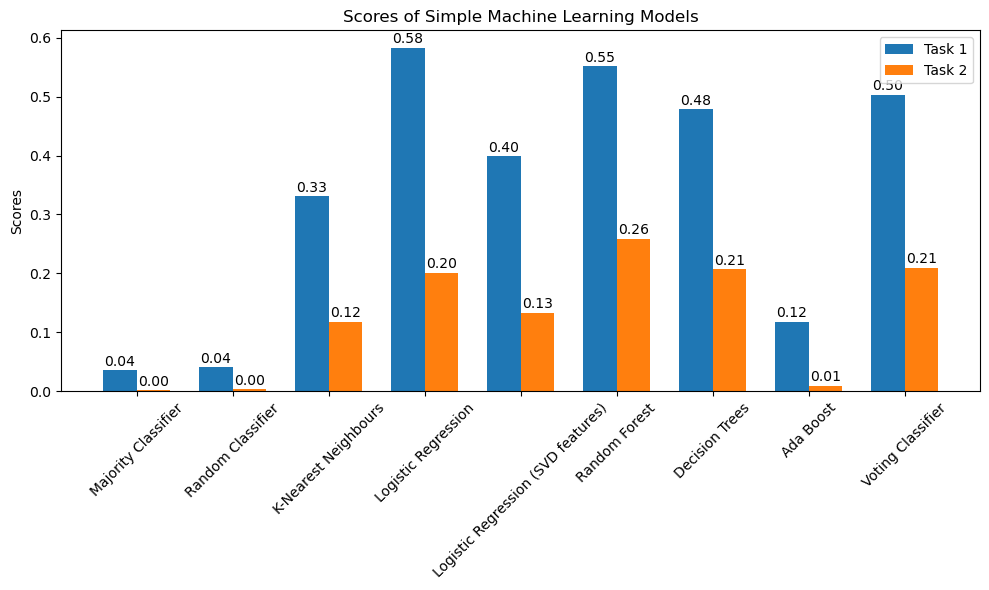

In [71]:
plot_model_scores(ml_model_scores, 'Scores of Simple Machine Learning Models')

Now, we will analyze the results of the most advanced BERT-like models on the test dataset. Similarly, we will use the `bert_like_test_pred` dictionary, which we defined earlier, containing the predictions of these models on the test set.

In [75]:
bert_like_scores = {}

for model_name, model_pred in bert_like_test_pred.items():
    subtask_1_score = compute_score(testset['hazard-category'], testset['product-category'],
                                    model_pred['hazard-category'], model_pred['product-category'])
    subtask_2_score = compute_score(testset['hazard'], testset['product'],
                                    model_pred['hazard'], model_pred['product'])

    model_score = [subtask_1_score, subtask_2_score]

    bert_like_scores[model_name] = model_score

Now that we have created the `bert_like_scores` dictionary from the predictions, we can call our `plot_model_scores` function to clearly analyze how our models perform on the test set for both subtasks.

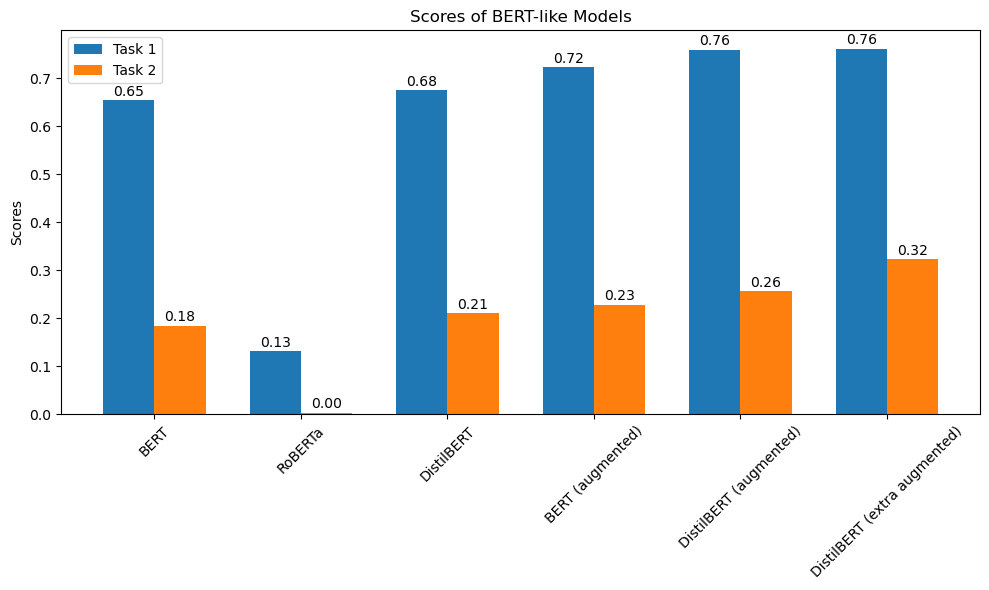

In [76]:
plot_model_scores(bert_like_scores, 'Scores of BERT-like Models')

As we can see from the visualization above, our best model based on the results from the test set is **DistilBERT (Extra Augmented)***. Although we conducted the final evaluation ourselves, we will still generate the `submission.csv` and zip it, which will contain the labels predicted by our model for all four of the target labels. This can be done easily by following the code provided in the code examples

In [77]:
# save predictions to a new folder
os.makedirs('./submission/', exist_ok=True)
extra_aug_distilbert_test_pred.to_csv('./submission/submission.csv')

# zip the folder (zipfile can be directly uploaded to codalab)
make_archive('./submission', 'zip', './submission')

'/home/ipantelidis/submission.zip'